# Trajectory Optimization using MILP

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/milp_path.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

First we'll need some libraries including the [PuLP linear programming library](https://coin-or.github.io/pulp/).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
!pip install pulp
from pulp import *

## Problem definition

Start by defining some obstacles in the form of boxes, [left,bottom,right,top], and plot them.

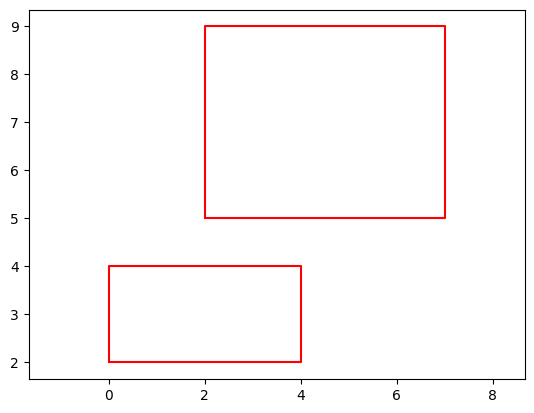

In [2]:
obstacles = np.array([(0,2,4,4),(2,5,7,9)])

def plot_obst_box(b):
  plt.plot(b[[0,0,2,2,0]],b[[1,3,3,1,1]],'r')

for ob in obstacles:
  plot_obst_box(ob)

plt.axis('equal')
plt.show()

Also define a start and end state - including both position and velocity, hence a 4D vector.

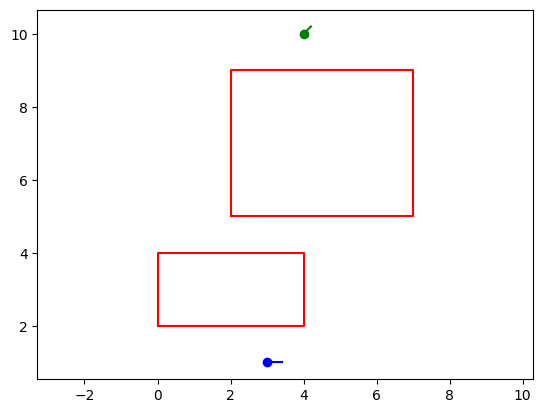

In [3]:
x_start = np.array([3,1,2,0])
x_goal = np.array([4,10,1,1])

def plot_state(x, col, dt = 0.2):
  plt.plot(x[0],x[1],col+'o')
  plt.plot([x[0],x[0]+dt*x[2]],[x[1],x[1]+dt*x[3]],col+'-')

plot_state(x_goal,'g')
plot_state(x_start, 'b')

for ob in obstacles:
  plot_obst_box(ob)

plt.axis('equal')
plt.show()

Define a dynamics model $A,B$ for a standard model $x(k+1) = Ax(k)+Bu(k)$.  I'll use a simple double integrator ("SUVAT") model with acceperation inputs.

In [4]:
time_step = 0.5
A = np.array([[1., 0., time_step, 0.],[0., 1., 0., time_step],[0., 0., 1., 0.],[0., 0., 0., 1.]])
B = np.array([[0.5*time_step*time_step, 0.],[0., 0.5*time_step*time_step],[time_step, 0.], [0., time_step]])
print(A)
print(B)

[[1.  0.  0.5 0. ]
 [0.  1.  0.  0.5]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]
[[0.125 0.   ]
 [0.    0.125]
 [0.5   0.   ]
 [0.    0.5  ]]


Finally define some limits on state and acceleration input.

In [5]:
x_lower_limit = np.array([-10., -10, -3., -3.])
x_upper_limit = np.array([10., 10, 3., 3.])
u_lower_limit = np.array([-5., -5.])
u_upper_limit = np.array([5., 5.])

## The MILP optimization

Create a new optimization model and include decision variables for the states and inputs over a fixed time horizon.

In [6]:
num_steps = 12
num_states = len(x_lower_limit)
num_inputs = len(u_lower_limit)

prob = LpProblem('path',LpMinimize)
x = LpVariable.dicts("x",(range(num_states),range(num_steps)))
u = LpVariable.dicts("u",(range(num_inputs),range(num_steps)))
print(x)

{0: {0: x_0_0, 1: x_0_1, 2: x_0_2, 3: x_0_3, 4: x_0_4, 5: x_0_5, 6: x_0_6, 7: x_0_7, 8: x_0_8, 9: x_0_9, 10: x_0_10, 11: x_0_11}, 1: {0: x_1_0, 1: x_1_1, 2: x_1_2, 3: x_1_3, 4: x_1_4, 5: x_1_5, 6: x_1_6, 7: x_1_7, 8: x_1_8, 9: x_1_9, 10: x_1_10, 11: x_1_11}, 2: {0: x_2_0, 1: x_2_1, 2: x_2_2, 3: x_2_3, 4: x_2_4, 5: x_2_5, 6: x_2_6, 7: x_2_7, 8: x_2_8, 9: x_2_9, 10: x_2_10, 11: x_2_11}, 3: {0: x_3_0, 1: x_3_1, 2: x_3_2, 3: x_3_3, 4: x_3_4, 5: x_3_5, 6: x_3_6, 7: x_3_7, 8: x_3_8, 9: x_3_9, 10: x_3_10, 11: x_3_11}}


Initial and final value constraints.

In [7]:
for n in range(num_states):
  prob += (x[n][0]==x_start[n])
  prob += (x[n][num_steps-1]==x_goal[n])

prob

path:
MINIMIZE
None
SUBJECT TO
_C1: x_0_0 = 3

_C2: x_0_11 = 4

_C3: x_1_0 = 1

_C4: x_1_11 = 10

_C5: x_2_0 = 2

_C6: x_2_11 = 1

_C7: x_3_0 = 0

_C8: x_3_11 = 1

VARIABLES
x_0_0 free Continuous
x_0_11 free Continuous
x_1_0 free Continuous
x_1_11 free Continuous
x_2_0 free Continuous
x_2_11 free Continuous
x_3_0 free Continuous
x_3_11 free Continuous

Now add the dynamics constraints.  This rather clumsily reproduces matrix multiplication in code, but PuLP doesn't handle matrix arithmetic natively, so we have to help.

In [8]:
for k in range(num_steps - 1):
  for n in range(num_states):
    prob += (x[n][k+1]==sum([A[n,m]*x[m][k] for m in range(num_states)] + [B[n,p]*u[p][k] for p in range(num_inputs)]))

prob

path:
MINIMIZE
None
SUBJECT TO
_C1: x_0_0 = 3

_C2: x_0_11 = 4

_C3: x_1_0 = 1

_C4: x_1_11 = 10

_C5: x_2_0 = 2

_C6: x_2_11 = 1

_C7: x_3_0 = 0

_C8: x_3_11 = 1

_C9: - 0.125 u_0_0 - x_0_0 + x_0_1 - 0.5 x_2_0 = 0

_C10: - 0.125 u_1_0 - x_1_0 + x_1_1 - 0.5 x_3_0 = 0

_C11: - 0.5 u_0_0 - x_2_0 + x_2_1 = 0

_C12: - 0.5 u_1_0 - x_3_0 + x_3_1 = 0

_C13: - 0.125 u_0_1 - x_0_1 + x_0_2 - 0.5 x_2_1 = 0

_C14: - 0.125 u_1_1 - x_1_1 + x_1_2 - 0.5 x_3_1 = 0

_C15: - 0.5 u_0_1 - x_2_1 + x_2_2 = 0

_C16: - 0.5 u_1_1 - x_3_1 + x_3_2 = 0

_C17: - 0.125 u_0_2 - x_0_2 + x_0_3 - 0.5 x_2_2 = 0

_C18: - 0.125 u_1_2 - x_1_2 + x_1_3 - 0.5 x_3_2 = 0

_C19: - 0.5 u_0_2 - x_2_2 + x_2_3 = 0

_C20: - 0.5 u_1_2 - x_3_2 + x_3_3 = 0

_C21: - 0.125 u_0_3 - x_0_3 + x_0_4 - 0.5 x_2_3 = 0

_C22: - 0.125 u_1_3 - x_1_3 + x_1_4 - 0.5 x_3_3 = 0

_C23: - 0.5 u_0_3 - x_2_3 + x_2_4 = 0

_C24: - 0.5 u_1_3 - x_3_3 + x_3_4 = 0

_C25: - 0.125 u_0_4 - x_0_4 + x_0_5 - 0.5 x_2_4 = 0

_C26: - 0.125 u_1_4 - x_1_4 + x_1_5 - 0.5 x_3_4 

Add the limits

In [9]:
for k in range(1,num_steps-1):
  for n in range(num_states):
    prob += (x[n][k] >= x_lower_limit[n])
    prob += (x[n][k] <= x_upper_limit[n])
  for p in range(num_inputs):
    prob += (u[p][k] >= u_lower_limit[p])
    prob += (u[p][k] <= u_upper_limit[p])

prob

path:
MINIMIZE
None
SUBJECT TO
_C1: x_0_0 = 3

_C2: x_0_11 = 4

_C3: x_1_0 = 1

_C4: x_1_11 = 10

_C5: x_2_0 = 2

_C6: x_2_11 = 1

_C7: x_3_0 = 0

_C8: x_3_11 = 1

_C9: - 0.125 u_0_0 - x_0_0 + x_0_1 - 0.5 x_2_0 = 0

_C10: - 0.125 u_1_0 - x_1_0 + x_1_1 - 0.5 x_3_0 = 0

_C11: - 0.5 u_0_0 - x_2_0 + x_2_1 = 0

_C12: - 0.5 u_1_0 - x_3_0 + x_3_1 = 0

_C13: - 0.125 u_0_1 - x_0_1 + x_0_2 - 0.5 x_2_1 = 0

_C14: - 0.125 u_1_1 - x_1_1 + x_1_2 - 0.5 x_3_1 = 0

_C15: - 0.5 u_0_1 - x_2_1 + x_2_2 = 0

_C16: - 0.5 u_1_1 - x_3_1 + x_3_2 = 0

_C17: - 0.125 u_0_2 - x_0_2 + x_0_3 - 0.5 x_2_2 = 0

_C18: - 0.125 u_1_2 - x_1_2 + x_1_3 - 0.5 x_3_2 = 0

_C19: - 0.5 u_0_2 - x_2_2 + x_2_3 = 0

_C20: - 0.5 u_1_2 - x_3_2 + x_3_3 = 0

_C21: - 0.125 u_0_3 - x_0_3 + x_0_4 - 0.5 x_2_3 = 0

_C22: - 0.125 u_1_3 - x_1_3 + x_1_4 - 0.5 x_3_3 = 0

_C23: - 0.5 u_0_3 - x_2_3 + x_2_4 = 0

_C24: - 0.5 u_1_3 - x_3_3 + x_3_4 = 0

_C25: - 0.125 u_0_4 - x_0_4 + x_0_5 - 0.5 x_2_4 = 0

_C26: - 0.125 u_1_4 - x_1_4 + x_1_5 - 0.5 x_3_4 

Although we haven't set an obective, we can just ask for any old solution to the constraints at this point.

In [10]:
prob2 = prob.copy()
prob2.solve()
print("Status:", LpStatus[prob2.status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/5v/8ygvppms6tj1217vhdh1b8f40000gn/T/c34e29bde18d446db0de0b5393af438b-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/5v/8ygvppms6tj1217vhdh1b8f40000gn/T/c34e29bde18d446db0de0b5393af438b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 177 COLUMNS
At line 461 RHS
At line 634 BOUNDS
At line 706 ENDATA
Problem MODEL has 172 rows, 71 columns and 282 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 29 (-143) rows, 47 (-24) columns and 110 (-172) elements
0  Obj 0 Primal inf 240.86626 (28) Dual inf 44.592895 (38)
34  Obj 0 Primal inf 22.973235 (7) Dual inf 4.7470301 (6)
44  Obj 0
Optimal - objective value 0
After Postsolve, objective 0, infeasibilities - dual 0 (0), prima

We can't expect a very good path yet, but it should at least connect start to goal.

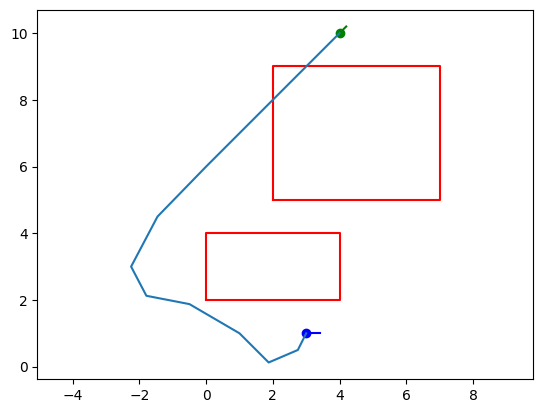

In [11]:
def plot_traj(x):
  plt.plot([x[0][k].varValue for k in range(num_steps)],[x[1][k].varValue for k in range(num_steps)])

plot_state(x_goal,'g')
plot_state(x_start, 'b')

for ob in obstacles:
  plot_obst_box(ob)

plot_traj(x)

plt.axis('equal')
plt.show()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/5v/8ygvppms6tj1217vhdh1b8f40000gn/T/1f6d2570597448dea8d4858e0e78a955-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/5v/8ygvppms6tj1217vhdh1b8f40000gn/T/1f6d2570597448dea8d4858e0e78a955-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 225 COLUMNS
At line 628 RHS
At line 849 BOUNDS
At line 946 ENDATA
Problem MODEL has 220 rows, 96 columns and 378 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 73 (-147) rows, 69 (-27) columns and 198 (-180) elements
Perturbing problem by 0.001% of 1.2968396 - largest nonzero change 5.6129133e-05 ( 0.0043376822%) - largest zero change 4.9982313e-05
0  Obj -108.20589 Primal inf 435.1549 (72)
40  Obj -91.799222 Primal inf 273.14569 (54

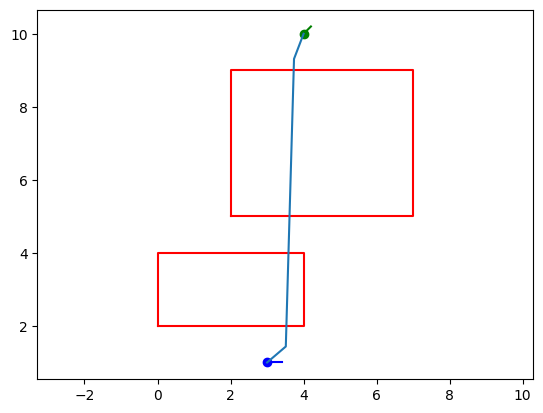

In [12]:
um = LpVariable.dicts("um",(range(num_inputs),range(num_steps)))
for k in range(num_steps):
  for p in range(num_inputs):
    prob += (um[p][k]>=u[p][k])
    prob += (um[p][k]>=-u[p][k])

prob.setObjective(sum([um[p][k] for k in range(num_steps) for p in range(num_inputs)]))

prob3 = prob.copy()
prob3.solve()

plot_state(x_goal,'g')
plot_state(x_start, 'b')

for ob in obstacles:
  plot_obst_box(ob)

plot_traj(x)

plt.axis('equal')
plt.show()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/5v/8ygvppms6tj1217vhdh1b8f40000gn/T/7c2ff304b2144a02ba5367098ab3b7ce-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/5v/8ygvppms6tj1217vhdh1b8f40000gn/T/7c2ff304b2144a02ba5367098ab3b7ce-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 335 COLUMNS
At line 1178 RHS
At line 1509 BOUNDS
At line 1694 ENDATA
Problem MODEL has 330 rows, 184 columns and 642 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10.8 - 0.00 seconds
Cgl0003I 1 fixed, 0 tightened bounds, 33 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 16 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 8 strengthened rows, 0 substitutions
Cgl00

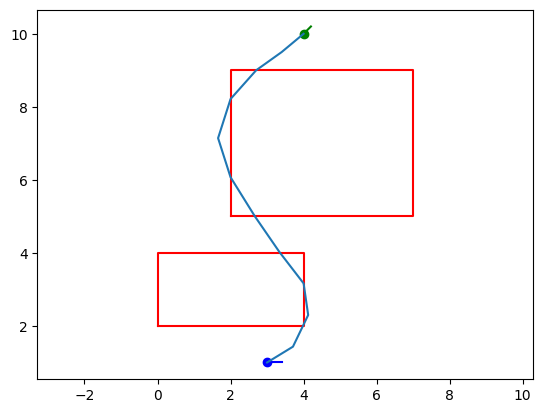

In [13]:
b = LpVariable.dicts("b",(range(len(obstacles)),range(4),range(num_steps)),lowBound=0,upBound=1,cat='Integer')
bigM = 10

for k in range(num_steps-1):
  for q in range(len(obstacles)):
    prob += (x[0][k]<=obstacles[q][0] + bigM*b[q][0][k])
    prob += (x[1][k]<=obstacles[q][1] + bigM*b[q][1][k])
    prob += (x[0][k]>=obstacles[q][2] - bigM*b[q][2][k])
    prob += (x[1][k]>=obstacles[q][3] - bigM*b[q][3][k])
    prob += (sum([b[q][d][k] for d in range(4)])<=3)
    
prob4 = prob.copy()
prob4.solve()
print("Status:", LpStatus[prob4.status])

plot_state(x_goal,'g')
plot_state(x_start, 'b')

for ob in obstacles:
  plot_obst_box(ob)

plot_traj(x)

plt.axis('equal')
plt.show()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/5v/8ygvppms6tj1217vhdh1b8f40000gn/T/bc5701fa064640499b43390f74c78ede-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/5v/8ygvppms6tj1217vhdh1b8f40000gn/T/bc5701fa064640499b43390f74c78ede-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 423 COLUMNS
At line 1442 RHS
At line 1861 BOUNDS
At line 2046 ENDATA
Problem MODEL has 418 rows, 184 columns and 818 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10.8 - 0.00 seconds
Cgl0003I 3 fixed, 0 tightened bounds, 58 strengthened rows, 0 substitutions
Cgl0003I 1 fixed, 0 tightened bounds, 31 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 18 strengthened rows, 0 substitutions
Cgl0

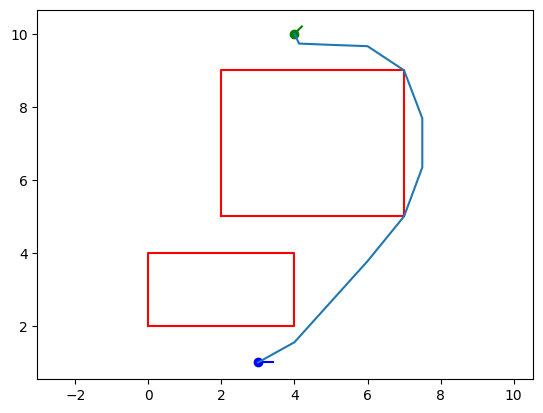

In [14]:
for k in range(num_steps-1):
  for q in range(len(obstacles)):
    prob += (x[0][k+1]<=obstacles[q][0] + bigM*b[q][0][k])
    prob += (x[1][k+1]<=obstacles[q][1] + bigM*b[q][1][k])
    prob += (x[0][k+1]>=obstacles[q][2] - bigM*b[q][2][k])
    prob += (x[1][k+1]>=obstacles[q][3] - bigM*b[q][3][k])
    
prob.solve()
print("Status:", LpStatus[prob.status])

plot_state(x_goal,'g')
plot_state(x_start, 'b')

for ob in obstacles:
  plot_obst_box(ob)

plot_traj(x)

plt.axis('equal')
plt.show()

In [15]:
for q in range(len(obstacles)):
  for k in range(num_steps-1):
    print(b[q][0][k],':',b[q][0][k].varValue)
    print(b[q][1][k],':',b[q][1][k].varValue)
    print(b[q][2][k],':',b[q][2][k].varValue)
    print(b[q][3][k],':',b[q][3][k].varValue)

b_0_0_0 : 1.0
b_0_1_0 : 0.0
b_0_2_0 : 1.0
b_0_3_0 : 1.0
b_0_0_1 : 1.0
b_0_1_1 : 1.0
b_0_2_1 : 0.0
b_0_3_1 : 1.0
b_0_0_2 : 1.0
b_0_1_2 : 1.0
b_0_2_2 : 0.0
b_0_3_2 : 1.0
b_0_0_3 : 1.0
b_0_1_3 : 1.0
b_0_2_3 : 0.0
b_0_3_3 : 1.0
b_0_0_4 : 1.0
b_0_1_4 : 1.0
b_0_2_4 : 1.0
b_0_3_4 : 0.0
b_0_0_5 : 1.0
b_0_1_5 : 1.0
b_0_2_5 : 1.0
b_0_3_5 : 0.0
b_0_0_6 : 1.0
b_0_1_6 : 1.0
b_0_2_6 : 0.0
b_0_3_6 : 1.0
b_0_0_7 : 1.0
b_0_1_7 : 1.0
b_0_2_7 : 1.0
b_0_3_7 : 0.0
b_0_0_8 : 1.0
b_0_1_8 : 1.0
b_0_2_8 : 1.0
b_0_3_8 : 0.0
b_0_0_9 : 1.0
b_0_1_9 : 1.0
b_0_2_9 : 1.0
b_0_3_9 : 0.0
b_0_0_10 : 1.0
b_0_1_10 : 1.0
b_0_2_10 : 1.0
b_0_3_10 : 0.0
b_1_0_0 : 1.0
b_1_1_0 : 0.0
b_1_2_0 : 1.0
b_1_3_0 : 1.0
b_1_0_1 : 1.0
b_1_1_1 : 0.0
b_1_2_1 : 1.0
b_1_3_1 : 1.0
b_1_0_2 : 1.0
b_1_1_2 : 0.0
b_1_2_2 : 1.0
b_1_3_2 : 1.0
b_1_0_3 : 1.0
b_1_1_3 : 0.0
b_1_2_3 : 1.0
b_1_3_3 : 1.0
b_1_0_4 : 1.0
b_1_1_4 : 1.0
b_1_2_4 : 0.0
b_1_3_4 : 1.0
b_1_0_5 : 1.0
b_1_1_5 : 1.0
b_1_2_5 : 0.0
b_1_3_5 : 1.0
b_1_0_6 : 1.0
b_1_1_6 : 1.0
b_1_2_6 : 0.0
b_